In [1]:
!pip install breeze-connect pandas numpy matplotlib seaborn
!pip install py_vollib mibian hmmlearn scikit-learn xgboost tensorflow


In [8]:
from breeze_connect import BreezeConnect
breeze = BreezeConnect(api_key="292fO920P_09t388d9g641013E6q9UI2")
breeze.generate_session(api_secret="264e16@3597546nO7%8980598991631j",session_token="54398448")


In [9]:
import pandas as pd
from datetime import datetime, timedelta

from_date = "2024-01-15T09:15:00.000Z"
to_date   = "2025-01-15T15:30:00.000Z"


In [10]:
def last_data(year, month):
    if month == 12:
        last_day = datetime(year, month, 31)
    else:
        last_day = datetime(year, month + 1, 1) - timedelta(days=1)

    while last_day.weekday() != 3:  # Thursday = 3
        last_day -= timedelta(days=1)

    return last_day.strftime("%Y-%m-%d")


In [11]:
start_date = datetime(2024, 1, 1)
end_date   = datetime(2025, 1, 1)

expiry_dates = []
current = start_date

while current <= end_date:
    expiry_dates.append(last_data(current.year, current.month))
    current = current.replace(day=1) + timedelta(days=32)
    current = current.replace(day=1)

print("Expiry Dates:", expiry_dates)


Expiry Dates: ['2024-01-25', '2024-02-29', '2024-03-28', '2024-04-25', '2024-05-30', '2024-06-27', '2024-07-25', '2024-08-29', '2024-09-26', '2024-10-31', '2024-11-28', '2024-12-26', '2025-01-30']


In [12]:
futures_all = []

for expiry in expiry_dates:
    print(f"\nFetching futures for expiry: {expiry}")

    try:
        fut_data = breeze.get_historical_data(
            interval="5minute",
            from_date="2024-01-01T09:15:00.000Z",
            to_date="2025-01-01T15:30:00.000Z",
            stock_code="NIFTY",
            exchange_code="NFO",
            product_type="futures",
            expiry_date=expiry
        )

        if "Success" in fut_data and fut_data["Success"]:
            df = pd.DataFrame(fut_data["Success"])
            df["expiry"] = expiry
            futures_all.append(df)
            print(f"Data fetched: {len(df)} rows")
        else:
            print("No data returned")

    except Exception as e:
        print(f"Error for expiry {expiry}:", e)



Fetching futures for expiry: 2024-01-25
Data fetched: 1425 rows

Fetching futures for expiry: 2024-02-29
Data fetched: 3220 rows

Fetching futures for expiry: 2024-03-28
Data fetched: 4588 rows

Fetching futures for expiry: 2024-04-25
Data fetched: 4363 rows

Fetching futures for expiry: 2024-05-30
Data fetched: 4316 rows

Fetching futures for expiry: 2024-06-27
Data fetched: 4440 rows

Fetching futures for expiry: 2024-07-25
Data fetched: 4591 rows

Fetching futures for expiry: 2024-08-29
Data fetched: 4647 rows

Fetching futures for expiry: 2024-09-26
Data fetched: 4722 rows

Fetching futures for expiry: 2024-10-31
Data fetched: 5087 rows

Fetching futures for expiry: 2024-11-28
Data fetched: 4574 rows

Fetching futures for expiry: 2024-12-26
Data fetched: 4520 rows

Fetching futures for expiry: 2025-01-30
Data fetched: 2939 rows


In [13]:
if futures_all:
    df_futures = pd.concat(futures_all, ignore_index=True)

    df_futures["datetime"] = pd.to_datetime(df_futures["datetime"]) #Future dataset call
    df_futures.sort_values("datetime", inplace=True)

    df_futures.to_csv(
        "C:/Users/HP/Desktop/MLQuest/dataset/nifty_futures_5min.csv",
        index=False
    )

    print("\n NIFTY Futures data saved successfully")
    print("Total rows:", len(df_futures))
else:
    print("\n No futures data fetched — CSV not created")



 NIFTY Futures data saved successfully
Total rows: 53432


In [15]:
spot_df = pd.read_csv("C:/Users/HP/Desktop/MLQuest/dataset/nifty_spot_5min.csv")  #Name of Data Base for 
spot_df["datetime"] = pd.to_datetime(spot_df["datetime"])
print("Spot data loaded:", len(spot_df))


Spot data loaded: 24413


### def get_atm(price, step=50):
    return int(round(price / step) * step)
options_all = []

for expiry in expiry_dates:
    expiry_dt = datetime.strptime(expiry, "%Y-%m-%d")

    
    from_date = (expiry_dt - timedelta(days=30)).strftime("%Y-%m-%dT09:15:00.000Z")
    to_date   = expiry_dt.strftime("%Y-%m-%dT15:30:00.000Z")

    print(f"\nFetching options for expiry: {expiry}")
    print("From:", from_date, "To:", to_date)

    
    spot_slice = spot_df[spot_df["datetime"] <= expiry_dt]

    if spot_slice.empty:
        print("No spot price available, skipping expiry")
        continue

    spot_price = spot_slice.iloc[-1]["close"]
    atm = get_atm(spot_price)

    strikes = [atm - 100, atm - 50, atm, atm + 50, atm + 100]

    for strike in strikes:
        for right in ["call", "put"]:
            try:
                opt_data = breeze.get_historical_data(
                    interval="5minute",
                    from_date=from_date,
                    to_date=to_date,
                    stock_code="NIFTY",
                    exchange_code="NFO",
                    product_type="options",
                    expiry_date=expiry,
                    strike_price=strike,
                    right=right
                )

                if "Success" in opt_data and opt_data["Success"]:
                    df = pd.DataFrame(opt_data["Success"])
                    df["expiry"] = expiry
                    df["strike"] = strike
                    df["right"] = right
                    options_all.append(df)
                    print(f"{strike} {right.upper()} : {len(df)} rows")
                else:
                    print(f"No data for {strike} {right.upper()}")

            except Exception as e:
                print(f"Error {strike} {right.upper()} :", e)


In [17]:
if options_all:
    df_options = pd.concat(options_all, ignore_index=True)

    df_options["datetime"] = pd.to_datetime(df_options["datetime"]) #Options Dataset Call
    df_options.sort_values("datetime", inplace=True)

    df_options.to_csv(
        "C:/Users/HP/Desktop/MLQuest/dataset/nifty_options_5min.csv",
        index=False
    )

    print("\n NIFTY OPTIONS 5-MIN DATA SAVED")
    print("Total rows:", len(df_options))
else:
    print("\n No options data fetche")



 NIFTY OPTIONS 5-MIN DATA SAVED
Total rows: 191574


In [18]:
df_futures.isnull().sum()
print("---------------")
df_futures.info()

---------------
<class 'pandas.core.frame.DataFrame'>
Index: 53432 entries, 0 to 53431
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       53432 non-null  datetime64[ns]
 1   stock_code     53432 non-null  object        
 2   exchange_code  53432 non-null  object        
 3   product_type   53432 non-null  object        
 4   expiry_date    53432 non-null  object        
 5   right          53432 non-null  object        
 6   strike_price   53432 non-null  object        
 7   open           53432 non-null  object        
 8   high           53432 non-null  object        
 9   low            53432 non-null  object        
 10  close          53432 non-null  object        
 11  volume         53432 non-null  object        
 12  open_interest  53432 non-null  object        
 13  count          53432 non-null  int64         
 14  expiry         53432 non-null  object        
dtypes: datet

In [19]:
df_futures.head(10)

,datetime,stock_code,exchange_code,product_type,expiry_date,right,strike_price,open,high,low,close,volume,open_interest,count,expiry
0,2024-01-01 09:15:00,NIFTY,NFO,Futures,25-JAN-24,Others,0,21849.8,21855.5,21820,21820.3,227500,12777750,0,2024-01-25
1425,2024-01-01 09:15:00,NIFTY,NFO,Futures,29-FEB-24,Others,0,21975,21976.1,21955.05,21959.8,11300,967900,0,2024-02-29
4645,2024-01-01 09:15:00,NIFTY,NFO,Futures,28-MAR-24,Others,0,22105,22113,22094,22094,2250,57950,0,2024-03-28
1,2024-01-01 09:20:00,NIFTY,NFO,Futures,25-JAN-24,Others,0,21820.3,21829.6,21816.4,21828.3,126050,12775000,1,2024-01-25
1426,2024-01-01 09:20:00,NIFTY,NFO,Futures,29-FEB-24,Others,0,21958.9,21966.05,21952.4,21963.95,6600,965200,1,2024-02-29
4646,2024-01-01 09:20:00,NIFTY,NFO,Futures,28-MAR-24,Others,0,22094,22095.95,22081.55,22089.8,5250,59000,1,2024-03-28
1427,2024-01-01 09:25:00,NIFTY,NFO,Futures,29-FEB-24,Others,0,21964.5,21965,21955,21960,12650,959050,2,2024-02-29
4647,2024-01-01 09:25:00,NIFTY,NFO,Futures,28-MAR-24,Others,0,22085.7,22094.55,22085,22086.1,1400,60850,2,2024-03-28
2,2024-01-01 09:25:00,NIFTY,NFO,Futures,25-JAN-24,Others,0,21828.5,21835.65,21821.2,21826.6,88100,12783300,2,2024-01-25
1428,2024-01-01 09:30:00,NIFTY,NFO,Futures,29-FEB-24,Others,0,21959.1,21968.35,21947.6,21965,14350,959650,3,2024-02-29


In [20]:
df_options.info()
print("----------")
df_options.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 191574 entries, 0 to 191573
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   datetime       191574 non-null  datetime64[ns]
 1   stock_code     191574 non-null  object        
 2   exchange_code  191574 non-null  object        
 3   product_type   191574 non-null  object        
 4   expiry_date    191574 non-null  object        
 5   right          191574 non-null  object        
 6   strike_price   191574 non-null  object        
 7   open           191574 non-null  object        
 8   high           191574 non-null  object        
 9   low            191574 non-null  object        
 10  close          191574 non-null  object        
 11  volume         191574 non-null  object        
 12  open_interest  191574 non-null  object        
 13  count          191574 non-null  int64         
 14  expiry         191574 non-null  object        
 15  strik

datetime         0
stock_code       0
exchange_code    0
product_type     0
expiry_date      0
right            0
strike_price     0
open             0
high             0
low              0
close            0
volume           0
open_interest    0
count            0
expiry           0
strike           0
dtype: int64

In [21]:
df_options.head(10)

,datetime,stock_code,exchange_code,product_type,expiry_date,right,strike_price,open,high,low,close,volume,open_interest,count,expiry,strike
0,2023-12-26 09:15:00,NIFTY,NFO,Options,25-JAN-24,call,21350,433.4,449.5,430,447.1,5200,38250,0,2024-01-25,21350
8000,2023-12-26 09:15:00,NIFTY,NFO,Options,25-JAN-24,put,21450,289.5,289.5,281.65,288.55,650,28400,0,2024-01-25,21450
4779,2023-12-26 09:15:00,NIFTY,NFO,Options,25-JAN-24,put,21400,266.55,268.7,260.4,268.35,29250,430500,0,2024-01-25,21400
9714,2023-12-26 09:15:00,NIFTY,NFO,Options,25-JAN-24,call,21500,356.5,360.85,340.95,358.4,53200,1305150,0,2024-01-25,21500
3061,2023-12-26 09:15:00,NIFTY,NFO,Options,25-JAN-24,call,21400,410.8,420,400,415.85,31600,489700,0,2024-01-25,21400
11439,2023-12-26 09:15:00,NIFTY,NFO,Options,25-JAN-24,put,21500,302,311.7,300.25,308.5,49950,1039450,0,2024-01-25,21500
13164,2023-12-26 09:15:00,NIFTY,NFO,Options,25-JAN-24,call,21550,328.05,333.5,328.05,332.5,1600,27100,0,2024-01-25,21550
1351,2023-12-26 09:15:00,NIFTY,NFO,Options,25-JAN-24,put,21350,250.6,251.8,244.55,250,4650,44650,0,2024-01-25,21350
14799,2023-12-26 09:15:00,NIFTY,NFO,Options,25-JAN-24,put,21550,331,333.5,331,333.5,700,25300,0,2024-01-25,21550
6504,2023-12-26 09:15:00,NIFTY,NFO,Options,25-JAN-24,call,21450,386.45,386.45,379.8,384.55,100,57000,0,2024-01-25,21450


In [22]:
spot_df.info()
print("--------------")
spot_df.isnull()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24413 entries, 0 to 24412
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       24413 non-null  datetime64[ns]
 1   stock_code     24413 non-null  object        
 2   exchange_code  24413 non-null  object        
 3   product_type   0 non-null      float64       
 4   expiry_date    0 non-null      float64       
 5   right          0 non-null      float64       
 6   strike_price   0 non-null      float64       
 7   open           24413 non-null  float64       
 8   high           24413 non-null  float64       
 9   low            24413 non-null  float64       
 10  close          24413 non-null  float64       
 11  volume         0 non-null      float64       
 12  open_interest  0 non-null      float64       
 13  count          24413 non-null  int64         
dtypes: datetime64[ns](1), float64(10), int64(1), object(2)
memory usage: 2

,datetime,stock_code,exchange_code,product_type,expiry_date,right,strike_price,open,high,low,close,volume,open_interest,count
0,False,False,False,True,True,True,True,False,False,False,False,True,True,False
1,False,False,False,True,True,True,True,False,False,False,False,True,True,False
2,False,False,False,True,True,True,True,False,False,False,False,True,True,False
3,False,False,False,True,True,True,True,False,False,False,False,True,True,False
4,False,False,False,True,True,True,True,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24408,False,False,False,True,True,True,True,False,False,False,False,True,True,False
24409,False,False,False,True,True,True,True,False,False,False,False,True,True,False
24410,False,False,False,True,True,True,True,False,False,False,False,True,True,False
24411,False,False,False,True,True,True,True,False,False,False,False,True,True,False


In [23]:
spot_df.isnull().sum()

datetime             0
stock_code           0
exchange_code        0
product_type     24413
expiry_date      24413
right            24413
strike_price     24413
open                 0
high                 0
low                  0
close                0
volume           24413
open_interest    24413
count                0
dtype: int64

In [24]:
# Preprocessing and Data Cleaning Step Here for All spot_df,df_options,df_futures
spot_df = spot_df.drop_duplicates()
spot_df

,datetime,stock_code,exchange_code,product_type,expiry_date,right,strike_price,open,high,low,close,volume,open_interest,count
0,2024-01-15 07:35:00,NIFTY,NSE,NaN,NaN,NaN,NaN,21894.55,21894.55,21894.55,21894.55,NaN,NaN,0
1,2024-01-15 07:40:00,NIFTY,NSE,NaN,NaN,NaN,NaN,21894.55,21894.55,21894.55,21894.55,NaN,NaN,1
2,2024-01-15 07:45:00,NIFTY,NSE,NaN,NaN,NaN,NaN,21894.55,21894.55,21894.55,21894.55,NaN,NaN,2
3,2024-01-15 07:50:00,NIFTY,NSE,NaN,NaN,NaN,NaN,21894.55,21894.55,21894.55,21894.55,NaN,NaN,3
4,2024-01-15 07:55:00,NIFTY,NSE,NaN,NaN,NaN,NaN,21894.55,21894.55,21894.55,21894.55,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24408,2025-01-15 15:40:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23213.20,23213.20,23213.20,23213.20,NaN,NaN,24408
24409,2025-01-15 15:45:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23213.20,23213.20,23213.20,23213.20,NaN,NaN,24409
24410,2025-01-15 15:50:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23213.20,23213.20,23213.20,23213.20,NaN,NaN,24410
24411,2025-01-15 15:55:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23213.20,23213.20,23213.20,23213.20,NaN,NaN,24411


In [25]:
df_options.drop_duplicates()
df_options

,datetime,stock_code,exchange_code,product_type,expiry_date,right,strike_price,open,high,low,close,volume,open_interest,count,expiry,strike
0,2023-12-26 09:15:00,NIFTY,NFO,Options,25-JAN-24,call,21350,433.4,449.5,430,447.1,5200,38250,0,2024-01-25,21350
8000,2023-12-26 09:15:00,NIFTY,NFO,Options,25-JAN-24,put,21450,289.5,289.5,281.65,288.55,650,28400,0,2024-01-25,21450
4779,2023-12-26 09:15:00,NIFTY,NFO,Options,25-JAN-24,put,21400,266.55,268.7,260.4,268.35,29250,430500,0,2024-01-25,21400
9714,2023-12-26 09:15:00,NIFTY,NFO,Options,25-JAN-24,call,21500,356.5,360.85,340.95,358.4,53200,1305150,0,2024-01-25,21500
3061,2023-12-26 09:15:00,NIFTY,NFO,Options,25-JAN-24,call,21400,410.8,420,400,415.85,31600,489700,0,2024-01-25,21400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185083,2025-01-30 15:25:00,NIFTY,NFO,Options,30-JAN-25,put,23200,.1,.2,.05,.15,6737050,7717250,1724,2025-01-30,23200
189848,2025-01-30 15:25:00,NIFTY,NFO,Options,30-JAN-25,call,23300,.15,.2,.1,.15,6865900,9257725,1678,2025-01-30,23300
186455,2025-01-30 15:25:00,NIFTY,NFO,Options,30-JAN-25,call,23250,.65,.9,.05,.2,35945800,10371350,1371,2025-01-30,23250
177026,2025-01-30 15:25:00,NIFTY,NFO,Options,30-JAN-25,call,23100,148.55,150.85,146.9,149.65,662475,3824225,1465,2025-01-30,23100


In [26]:
df_futures.drop_duplicates()
df_futures

,datetime,stock_code,exchange_code,product_type,expiry_date,right,strike_price,open,high,low,close,volume,open_interest,count,expiry
0,2024-01-01 09:15:00,NIFTY,NFO,Futures,25-JAN-24,Others,0,21849.8,21855.5,21820,21820.3,227500,12777750,0,2024-01-25
1425,2024-01-01 09:15:00,NIFTY,NFO,Futures,29-FEB-24,Others,0,21975,21976.1,21955.05,21959.8,11300,967900,0,2024-02-29
4645,2024-01-01 09:15:00,NIFTY,NFO,Futures,28-MAR-24,Others,0,22105,22113,22094,22094,2250,57950,0,2024-03-28
1,2024-01-01 09:20:00,NIFTY,NFO,Futures,25-JAN-24,Others,0,21820.3,21829.6,21816.4,21828.3,126050,12775000,1,2024-01-25
1426,2024-01-01 09:20:00,NIFTY,NFO,Futures,29-FEB-24,Others,0,21958.9,21966.05,21952.4,21963.95,6600,965200,1,2024-02-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53427,2025-01-01 15:05:00,NIFTY,NFO,Futures,30-JAN-25,Others,0,23882.65,23889.5,23880.2,23889.45,58650,13337675,2934,2025-01-30
53428,2025-01-01 15:10:00,NIFTY,NFO,Futures,30-JAN-25,Others,0,23886.1,23899,23882.3,23897.95,50325,13338600,2935,2025-01-30
53429,2025-01-01 15:15:00,NIFTY,NFO,Futures,30-JAN-25,Others,0,23895,23900,23886.9,23897.85,41175,13341375,2936,2025-01-30
53430,2025-01-01 15:20:00,NIFTY,NFO,Futures,30-JAN-25,Others,0,23899.6,23911,23895.45,23909.75,86225,13342750,2937,2025-01-30


In [27]:
#Ensuring the Date & Time formate of Datetime
spot_df['datetime'] = pd.to_datetime(spot_df["datetime"])
print(spot_df['datetime'].head(10))
print(spot_df['datetime'].dtype)

0   2024-01-15 07:35:00
1   2024-01-15 07:40:00
2   2024-01-15 07:45:00
3   2024-01-15 07:50:00
4   2024-01-15 07:55:00
5   2024-01-15 08:00:00
6   2024-01-15 08:05:00
7   2024-01-15 08:10:00
8   2024-01-15 08:15:00
9   2024-01-15 08:20:00
Name: datetime, dtype: datetime64[ns]
datetime64[ns]


In [28]:
df_options['datetime'] = pd.to_datetime(df_options["datetime"])
print(df_options['datetime'].head(10))
print(df_options['datetime'].dtype) # Finale Convertion of Datetime Formate of options

0       2023-12-26 09:15:00
8000    2023-12-26 09:15:00
4779    2023-12-26 09:15:00
9714    2023-12-26 09:15:00
3061    2023-12-26 09:15:00
11439   2023-12-26 09:15:00
13164   2023-12-26 09:15:00
1351    2023-12-26 09:15:00
14799   2023-12-26 09:15:00
6504    2023-12-26 09:15:00
Name: datetime, dtype: datetime64[ns]
datetime64[ns]


In [29]:
df_futures['datetime'].dtype


dtype('<M8[ns]')

In [30]:
df_futures['datetime'] = pd.to_datetime(df_futures['datetime'])
print(df_futures['datetime'].head(10),"\n--------\n",df_futures['datetime'].dtype) #Finale Convertion of Date time Columns in dateset

0      2024-01-01 09:15:00
1425   2024-01-01 09:15:00
4645   2024-01-01 09:15:00
1      2024-01-01 09:20:00
1426   2024-01-01 09:20:00
4646   2024-01-01 09:20:00
1427   2024-01-01 09:25:00
4647   2024-01-01 09:25:00
2      2024-01-01 09:25:00
1428   2024-01-01 09:30:00
Name: datetime, dtype: datetime64[ns] 
--------
 datetime64[ns]


In [31]:
#Sort All Data set before merging
spot_df = spot_df.sort_values("datetime").drop_duplicates()
print(spot_df.head(10))           

             datetime stock_code exchange_code  product_type  expiry_date  \
0 2024-01-15 07:35:00      NIFTY           NSE           NaN          NaN   
1 2024-01-15 07:40:00      NIFTY           NSE           NaN          NaN   
2 2024-01-15 07:45:00      NIFTY           NSE           NaN          NaN   
3 2024-01-15 07:50:00      NIFTY           NSE           NaN          NaN   
4 2024-01-15 07:55:00      NIFTY           NSE           NaN          NaN   
5 2024-01-15 08:00:00      NIFTY           NSE           NaN          NaN   
6 2024-01-15 08:05:00      NIFTY           NSE           NaN          NaN   
7 2024-01-15 08:10:00      NIFTY           NSE           NaN          NaN   
8 2024-01-15 08:15:00      NIFTY           NSE           NaN          NaN   
9 2024-01-15 08:20:00      NIFTY           NSE           NaN          NaN   

   right  strike_price      open      high       low     close  volume  \
0    NaN           NaN  21894.55  21894.55  21894.55  21894.55     NaN   
1   

In [32]:
df_futures = df_futures.sort_values("datetime").drop_duplicates()
print(df_futures.head(10))    

                datetime stock_code exchange_code product_type expiry_date  \
0    2024-01-01 09:15:00      NIFTY           NFO      Futures   25-JAN-24   
1425 2024-01-01 09:15:00      NIFTY           NFO      Futures   29-FEB-24   
4645 2024-01-01 09:15:00      NIFTY           NFO      Futures   28-MAR-24   
1    2024-01-01 09:20:00      NIFTY           NFO      Futures   25-JAN-24   
1426 2024-01-01 09:20:00      NIFTY           NFO      Futures   29-FEB-24   
4646 2024-01-01 09:20:00      NIFTY           NFO      Futures   28-MAR-24   
1427 2024-01-01 09:25:00      NIFTY           NFO      Futures   29-FEB-24   
4647 2024-01-01 09:25:00      NIFTY           NFO      Futures   28-MAR-24   
2    2024-01-01 09:25:00      NIFTY           NFO      Futures   25-JAN-24   
1428 2024-01-01 09:30:00      NIFTY           NFO      Futures   29-FEB-24   

       right strike_price     open      high       low     close  volume  \
0     Others            0  21849.8   21855.5     21820   21820.3 

In [33]:
df_options = df_options.sort_values("datetime").drop_duplicates()
print(df_options.head(10))    

                 datetime stock_code exchange_code product_type expiry_date  \
0     2023-12-26 09:15:00      NIFTY           NFO      Options   25-JAN-24   
8000  2023-12-26 09:15:00      NIFTY           NFO      Options   25-JAN-24   
4779  2023-12-26 09:15:00      NIFTY           NFO      Options   25-JAN-24   
9714  2023-12-26 09:15:00      NIFTY           NFO      Options   25-JAN-24   
3061  2023-12-26 09:15:00      NIFTY           NFO      Options   25-JAN-24   
11439 2023-12-26 09:15:00      NIFTY           NFO      Options   25-JAN-24   
13164 2023-12-26 09:15:00      NIFTY           NFO      Options   25-JAN-24   
1351  2023-12-26 09:15:00      NIFTY           NFO      Options   25-JAN-24   
14799 2023-12-26 09:15:00      NIFTY           NFO      Options   25-JAN-24   
6504  2023-12-26 09:15:00      NIFTY           NFO      Options   25-JAN-24   

      right strike_price    open    high     low   close volume open_interest  \
0      call        21350   433.4   449.5     430 

In [34]:
#Taking Base Candles from Spot dataframe
base_time = spot_df[["datetime"]].copy() #Create Copy of DataFrame for the Base for Merger the data
print(base_time)

                 datetime
0     2024-01-15 07:35:00
1     2024-01-15 07:40:00
2     2024-01-15 07:45:00
3     2024-01-15 07:50:00
4     2024-01-15 07:55:00
...                   ...
24408 2025-01-15 15:40:00
24409 2025-01-15 15:45:00
24410 2025-01-15 15:50:00
24411 2025-01-15 15:55:00
24412 2025-01-15 16:00:00

[24413 rows x 1 columns]


In [35]:
#Merge the Data grams
spot_futures = pd.merge(
    spot_df, df_futures, on="datetime", how="left",suffixes=("_spot","_fut")
)

print(spot_futures)

                 datetime stock_code_spot exchange_code_spot  \
0     2024-01-15 07:35:00           NIFTY                NSE   
1     2024-01-15 07:40:00           NIFTY                NSE   
2     2024-01-15 07:45:00           NIFTY                NSE   
3     2024-01-15 07:50:00           NIFTY                NSE   
4     2024-01-15 07:55:00           NIFTY                NSE   
...                   ...             ...                ...   
56758 2025-01-15 15:40:00           NIFTY                NSE   
56759 2025-01-15 15:45:00           NIFTY                NSE   
56760 2025-01-15 15:50:00           NIFTY                NSE   
56761 2025-01-15 15:55:00           NIFTY                NSE   
56762 2025-01-15 16:00:00           NIFTY                NSE   

       product_type_spot  expiry_date_spot  right_spot  strike_price_spot  \
0                    NaN               NaN         NaN                NaN   
1                    NaN               NaN         NaN                NaN   


In [36]:
atm_strike = df_options["strike_price"].mode()[0]
df_options_atm = df_options[df_options["strike_price"] == atm_strike]

print("ATM Strikes: ",atm_strike,"\n--------\n","Options ATM Strikes: ",df_options_atm)

ATM Strikes:  24300 
--------
 Options ATM Strikes:                    datetime stock_code exchange_code product_type expiry_date  \
91938  2024-06-25 09:15:00      NIFTY           NFO      Options   25-JUL-24   
93585  2024-06-25 09:15:00      NIFTY           NFO      Options   25-JUL-24   
91939  2024-06-25 09:20:00      NIFTY           NFO      Options   25-JUL-24   
91940  2024-06-25 09:25:00      NIFTY           NFO      Options   25-JUL-24   
91941  2024-06-25 09:30:00      NIFTY           NFO      Options   25-JUL-24   
...                    ...        ...           ...          ...         ...   
157853 2024-11-28 15:15:00      NIFTY           NFO      Options   28-NOV-24   
157854 2024-11-28 15:20:00      NIFTY           NFO      Options   28-NOV-24   
159362 2024-11-28 15:20:00      NIFTY           NFO      Options   28-NOV-24   
157855 2024-11-28 15:25:00      NIFTY           NFO      Options   28-NOV-24   
159363 2024-11-28 15:25:00      NIFTY           NFO      Options   

In [37]:
#merger spot + options
df_merge = pd.merge(
    spot_futures, df_options_atm, on="datetime",how="left", suffixes=("","_opt") )
print("The Output of Spotting and Merger: ",df_merge.head(20))
    

The Output of Spotting and Merger:                datetime stock_code_spot exchange_code_spot  product_type_spot  \
0  2024-01-15 07:35:00           NIFTY                NSE                NaN   
1  2024-01-15 07:40:00           NIFTY                NSE                NaN   
2  2024-01-15 07:45:00           NIFTY                NSE                NaN   
3  2024-01-15 07:50:00           NIFTY                NSE                NaN   
4  2024-01-15 07:55:00           NIFTY                NSE                NaN   
5  2024-01-15 08:00:00           NIFTY                NSE                NaN   
6  2024-01-15 08:05:00           NIFTY                NSE                NaN   
7  2024-01-15 08:10:00           NIFTY                NSE                NaN   
8  2024-01-15 08:15:00           NIFTY                NSE                NaN   
9  2024-01-15 08:20:00           NIFTY                NSE                NaN   
10 2024-01-15 08:25:00           NIFTY                NSE                NaN   
11 2

In [38]:
print(df_merge.info(),"\n-----Distance--Gape------\n",df_merge.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69932 entries, 0 to 69931
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            69932 non-null  datetime64[ns]
 1   stock_code_spot     69932 non-null  object        
 2   exchange_code_spot  69932 non-null  object        
 3   product_type_spot   0 non-null      float64       
 4   expiry_date_spot    0 non-null      float64       
 5   right_spot          0 non-null      float64       
 6   strike_price_spot   0 non-null      float64       
 7   open_spot           69932 non-null  float64       
 8   high_spot           69932 non-null  float64       
 9   low_spot            69932 non-null  float64       
 10  close_spot          69932 non-null  float64       
 11  volume_spot         0 non-null      float64       
 12  open_interest_spot  0 non-null      float64       
 13  count_spot          69932 non-null  int64     

In [76]:
end_merge.to_csv("C:/Users/HP/Desktop/MLQuest/dataset/nifty_merged_5min.csv",index=False) # Save the Merger Data Frame

In [39]:
import os
file_path = "C:/Users/HP/Desktop/MLQuest/dataset/nifty_merged_5min.csv"
if os.path.exists(file_path):
    df_exists = pd.read_csv(file_path)
    print("Show Case of Dataset",df_exists.head(10),"\n------dis---gap----\n""File Exist")
else:
    print("not exist")

Show Case of Dataset               datetime stock_code_spot exchange_code_spot  product_type_spot  \
0  2024-01-15 07:35:00           NIFTY                NSE                NaN   
1  2024-01-15 07:40:00           NIFTY                NSE                NaN   
2  2024-01-15 07:45:00           NIFTY                NSE                NaN   
3  2024-01-15 07:50:00           NIFTY                NSE                NaN   
4  2024-01-15 07:55:00           NIFTY                NSE                NaN   
5  2024-01-15 08:00:00           NIFTY                NSE                NaN   
6  2024-01-15 08:05:00           NIFTY                NSE                NaN   
7  2024-01-15 08:10:00           NIFTY                NSE                NaN   
8  2024-01-15 08:15:00           NIFTY                NSE                NaN   
9  2024-01-15 08:20:00           NIFTY                NSE                NaN   

   expiry_date_spot  right_spot  strike_price_spot  open_spot  high_spot  \
0               NaN   

C:\Users\HP\AppData\Local\Temp\ipykernel_26792\4285833882.py:4: DtypeWarning: Columns (28,29,30,31,32,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df_exists = pd.read_csv(file_path)


In [68]:
df = pd.read_csv("C:/Users/HP/Desktop/MLQuest/dataset/nifty_merged_5min.csv")

C:\Users\HP\AppData\Local\Temp\ipykernel_26792\469083040.py:1: DtypeWarning: Columns (28,29,30,31,32,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/HP/Desktop/MLQuest/dataset/nifty_merged_5min.csv")


In [69]:
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")
print(df.head(10))

             datetime stock_code_spot exchange_code_spot  product_type_spot  \
0 2024-01-15 07:35:00           NIFTY                NSE                NaN   
1 2024-01-15 07:40:00           NIFTY                NSE                NaN   
2 2024-01-15 07:45:00           NIFTY                NSE                NaN   
3 2024-01-15 07:50:00           NIFTY                NSE                NaN   
4 2024-01-15 07:55:00           NIFTY                NSE                NaN   
5 2024-01-15 08:00:00           NIFTY                NSE                NaN   
6 2024-01-15 08:05:00           NIFTY                NSE                NaN   
7 2024-01-15 08:10:00           NIFTY                NSE                NaN   
8 2024-01-15 08:15:00           NIFTY                NSE                NaN   
9 2024-01-15 08:20:00           NIFTY                NSE                NaN   

   expiry_date_spot  right_spot  strike_price_spot  open_spot  high_spot  \
0               NaN         NaN                NaN   2

In [70]:
df["ema_5"] = df["close_spot"].ewm(span=5, adjust=False).mean()
print(df)


                 datetime stock_code_spot exchange_code_spot  \
0     2024-01-15 07:35:00           NIFTY                NSE   
1     2024-01-15 07:40:00           NIFTY                NSE   
2     2024-01-15 07:45:00           NIFTY                NSE   
3     2024-01-15 07:50:00           NIFTY                NSE   
4     2024-01-15 07:55:00           NIFTY                NSE   
...                   ...             ...                ...   
43819 2025-01-15 15:40:00           NIFTY                NSE   
43820 2025-01-15 15:45:00           NIFTY                NSE   
43821 2025-01-15 15:50:00           NIFTY                NSE   
43822 2025-01-15 15:55:00           NIFTY                NSE   
43823 2025-01-15 16:00:00           NIFTY                NSE   

       product_type_spot  expiry_date_spot  right_spot  strike_price_spot  \
0                    NaN               NaN         NaN                NaN   
1                    NaN               NaN         NaN                NaN   


In [71]:
df["ema_15"] = df["close_spot"].ewm(span=15, adjust=False).mean()
df

,datetime,stock_code_spot,exchange_code_spot,product_type_spot,expiry_date_spot,right_spot,strike_price_spot,open_spot,high_spot,low_spot,...,high,low,close,volume,open_interest,count,expiry_opt,strike,ema_5,ema_15
0,2024-01-15 07:35:00,NIFTY,NSE,NaN,NaN,NaN,NaN,21894.55,21894.55,21894.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21894.550000,21894.550000
1,2024-01-15 07:40:00,NIFTY,NSE,NaN,NaN,NaN,NaN,21894.55,21894.55,21894.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21894.550000,21894.550000
2,2024-01-15 07:45:00,NIFTY,NSE,NaN,NaN,NaN,NaN,21894.55,21894.55,21894.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21894.550000,21894.550000
3,2024-01-15 07:50:00,NIFTY,NSE,NaN,NaN,NaN,NaN,21894.55,21894.55,21894.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21894.550000,21894.550000
4,2024-01-15 07:55:00,NIFTY,NSE,NaN,NaN,NaN,NaN,21894.55,21894.55,21894.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21894.550000,21894.550000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2025-01-15 15:40:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23213.20,23213.20,23213.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23215.426976,23208.878978
43820,2025-01-15 15:45:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23213.20,23213.20,23213.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23214.684651,23209.419106
43821,2025-01-15 15:50:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23213.20,23213.20,23213.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23214.189767,23209.891718
43822,2025-01-15 15:55:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23213.20,23213.20,23213.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23213.859845,23210.305253


In [72]:
print(df[["datetime", "close_spot", "ema_5", "ema_15"]].head(10))


             datetime  close_spot     ema_5    ema_15
0 2024-01-15 07:35:00    21894.55  21894.55  21894.55
1 2024-01-15 07:40:00    21894.55  21894.55  21894.55
2 2024-01-15 07:45:00    21894.55  21894.55  21894.55
3 2024-01-15 07:50:00    21894.55  21894.55  21894.55
4 2024-01-15 07:55:00    21894.55  21894.55  21894.55
5 2024-01-15 08:00:00    21894.55  21894.55  21894.55
6 2024-01-15 08:05:00    21894.55  21894.55  21894.55
7 2024-01-15 08:10:00    21894.55  21894.55  21894.55
8 2024-01-15 08:15:00    21894.55  21894.55  21894.55
9 2024-01-15 08:20:00    21894.55  21894.55  21894.55


In [73]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

In [74]:
df = pd.read_csv("C:/Users/HP/Desktop/MLQuest/dataset/nifty_merged_5min.csv")
df["datetime"] = pd.to_datetime(df_merge["datetime"])
df["datetime"]

C:\Users\HP\AppData\Local\Temp\ipykernel_26792\2391457785.py:1: DtypeWarning: Columns (28,29,30,31,32,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/HP/Desktop/MLQuest/dataset/nifty_merged_5min.csv")


0       2024-01-15 07:35:00
1       2024-01-15 07:40:00
2       2024-01-15 07:45:00
3       2024-01-15 07:50:00
4       2024-01-15 07:55:00
                ...        
43819   2025-01-15 15:40:00
43820   2025-01-15 15:45:00
43821   2025-01-15 15:50:00
43822   2025-01-15 15:55:00
43823   2025-01-15 16:00:00
Name: datetime, Length: 43824, dtype: datetime64[ns]

In [75]:
def bs_price(S, K, T, r, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


In [76]:
def implied_volatility(price, S, K, T, r, option_type):
    try:
        return brentq(
            lambda x: bs_price(S, K, T, r, x, option_type) - price,
            0.001, 5
        )
    except:
        return np.nan


In [81]:
import numpy as np
from scipy.stats import norm

def calculate_greeks(S, K, T, r, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Delta
    if option_type == "call":
        delta = norm.cdf(d1)
    else:
        delta = norm.cdf(d1) - 1

    # Gamma (same for call & put)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))

    # Vega (same for call & put)
    vega = S * norm.pdf(d1) * np.sqrt(T)

    # Theta
    if option_type == "call":
        theta = (
            -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
            - r * K * np.exp(-r * T) * norm.cdf(d2)
        )
    else:
        theta = (
            -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
            + r * K * np.exp(-r * T) * norm.cdf(-d2)
        )

    return delta, gamma, vega, theta


In [85]:
r = 0.06  # risk-free rate (6%)

df["T"] = (pd.to_datetime(df["expiry_date"]) - df["datetime"]).dt.days / 365
df = df[df["T"] > 0]

df["iv"] = df.apply(
    lambda x: implied_volatility(
        x["close"],        # option price
        x["close_spot"],   # spot price
        x["strike_price"],
        x["T"],
        r,
        x["right"]
    ),
    axis=1
)


C:\Users\HP\AppData\Local\Temp\ipykernel_26792\2849662583.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["T"] = (pd.to_datetime(df["expiry_date"]) - df["datetime"]).dt.days / 365


In [86]:
greeks = df.apply(
    lambda x: calculate_greeks(
        x["close_spot"],
        x["strike_price"],
        x["T"],
        r,
        x["iv"],
        x["right"]
    ), axis=1 )
df[["delta", "gamma", "vega", "theta"]] = pd.DataFrame(
    greeks.tolist(),
    index=df.index
)


In [113]:
df.to_csv("C:/Users/HP/Desktop/MLQuest/dataset/nifty_with_greeks.csv", index=False)

print("Options Greeks & IV completed")


Options Greeks & IV completed


In [114]:
df = pd.read_csv("C:/Users/HP/Desktop/MLQuest/dataset/nifty_with_greeks.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop = True)
df.head(10)

,datetime,stock_code_spot,exchange_code_spot,product_type_spot,expiry_date_spot,right_spot,strike_price_spot,open_spot,high_spot,low_spot,...,iv,delta,gamma,vega,theta,spot_return,pcr_oi_x,pcr_oi_y,pcr_oi,pcr_volume
0,2024-06-25 09:15:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23577.10,23590.90,23573.65,...,0.124732,0.208446,0.000346,1907.677787,-1786.658444,NaN,NaN,NaN,NaN,NaN
1,2024-06-25 09:15:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23577.10,23590.90,23573.65,...,0.124732,0.208446,0.000346,1907.677787,-1786.658444,0.000000,NaN,NaN,NaN,NaN
2,2024-06-25 09:20:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23586.70,23600.30,23572.90,...,0.110658,-0.819641,0.000357,1746.974973,-10.540271,0.000165,0.062750,0.062750,0.062750,0.0
3,2024-06-25 09:20:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23586.70,23600.30,23572.90,...,0.125011,0.210340,0.000347,1918.173193,-1800.910420,0.000000,0.062750,0.062750,0.062750,0.0
4,2024-06-25 09:20:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23586.70,23600.30,23572.90,...,0.110658,-0.819641,0.000357,1746.974973,-10.540271,0.000000,0.062750,0.062750,0.062750,0.0
5,2024-06-25 09:20:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23586.70,23600.30,23572.90,...,0.125011,0.210340,0.000347,1918.173193,-1800.910420,0.000000,0.062750,0.062750,0.062750,0.0
6,2024-06-25 09:25:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23589.55,23603.15,23581.40,...,0.124635,0.206651,0.000345,1897.576250,-1775.039337,-0.000363,0.061924,0.061924,0.061924,0.0
7,2024-06-25 09:25:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23589.55,23603.15,23581.40,...,0.112056,-0.819557,0.000353,1746.850438,-25.795406,0.000000,0.061924,0.061924,0.061924,0.0
8,2024-06-25 09:25:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23589.55,23603.15,23581.40,...,0.124635,0.206651,0.000345,1897.576250,-1775.039337,0.000000,0.061924,0.061924,0.061924,0.0
9,2024-06-25 09:25:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23589.55,23603.15,23581.40,...,0.112056,-0.819557,0.000353,1746.850438,-25.795406,0.000000,0.061924,0.061924,0.061924,0.0


In [115]:
# Spot Return 
df["spot_return"] = np.log(df["close_spot"]/df["close_spot"].shift(1))
df["spot_return"].head(10)

0         NaN
1    0.000000
2    0.000165
3    0.000000
4    0.000000
5    0.000000
6   -0.000363
7    0.000000
8    0.000000
9    0.000000
Name: spot_return, dtype: float64

In [116]:
calls = df[df["right"] == "call"]
puts  = df[df["right"] == "put"]
# Seperate Calls and puts

In [117]:
pcr_oi = (puts.groupby("datetime")["open_interest"].sum() / calls.groupby("datetime")["open_interest"].sum())


In [118]:
pcr_vol = (puts.groupby("datetime")["volume"].sum() / calls.groupby("datetime")["volume"].sum())

In [143]:
df = df.merge(pcr_oi.rename("pcr_oi"), on="datetime", how="left")
df = df.merge(pcr_vol.rename("pcr_volume"), on="datetime", how="left")

ValueError: You are trying to merge on object and datetime64[ns] columns for key 'datetime'. If you wish to proceed you should use pd.concat

In [144]:
df["right"].value_counts()

right
put     4286
call    4030
Name: count, dtype: int64

In [145]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [146]:
#Save to dataset
df.to_csv("C:/Users/HP/Desktop/MLQuest/dataset/nifty_features_final.csv", index=False)
print("Final dataset loaded")

Final dataset loaded


In [147]:
df =pd.read_csv("C:/Users/HP/Desktop/MLQuest/dataset/nifty_features_final.csv")
print(df.columns.tolist())

['datetime', 'stock_code_spot', 'exchange_code_spot', 'product_type_spot', 'expiry_date_spot', 'right_spot', 'strike_price_spot', 'open_spot', 'high_spot', 'low_spot', 'close_spot', 'volume_spot', 'open_interest_spot', 'count_spot', 'stock_code_fut', 'exchange_code_fut', 'product_type_fut', 'expiry_date_fut', 'right_fut', 'strike_price_fut', 'open_fut', 'high_fut', 'low_fut', 'close_fut', 'volume_fut', 'open_interest_fut', 'count_fut', 'expiry', 'stock_code', 'exchange_code', 'product_type', 'expiry_date', 'right', 'strike_price', 'open', 'high', 'low', 'close', 'volume', 'open_interest', 'count', 'expiry_opt', 'strike', 'T', 'iv', 'delta', 'gamma', 'vega', 'theta', 'spot_return', 'pcr_oi', 'pcr_volume', 'ema_5', 'ema_15']


In [148]:
df["close_spot"].head(10)

0    23586.05
1    23586.05
2    23589.95
3    23589.95
4    23589.95
5    23589.95
6    23581.40
7    23581.40
8    23581.40
9    23581.40
Name: close_spot, dtype: float64

In [149]:
df["ema_5"]  = df["close_spot"].ewm(span=5, adjust=False).mean()
df["ema_15"] = df["close_spot"].ewm(span=15, adjust=False).mean()
df[["close_spot", "ema_5", "ema_15"]].head(10)

,close_spot,ema_5,ema_15
0,23586.05,23586.050000,23586.050000
1,23586.05,23586.050000,23586.050000
2,23589.95,23587.350000,23586.537500
3,23589.95,23588.216667,23586.964063
4,23589.95,23588.794444,23587.337305
5,23589.95,23589.179630,23587.663892
6,23581.40,23586.586420,23586.880905
7,23581.40,23584.857613,23586.195792
8,23581.40,23583.705075,23585.596318
9,23581.40,23582.936717,23585.071778


In [150]:
df.to_csv("C:/Users/HP/Desktop/MLQuest/dataset/nifty_features_final.csv", index=False)

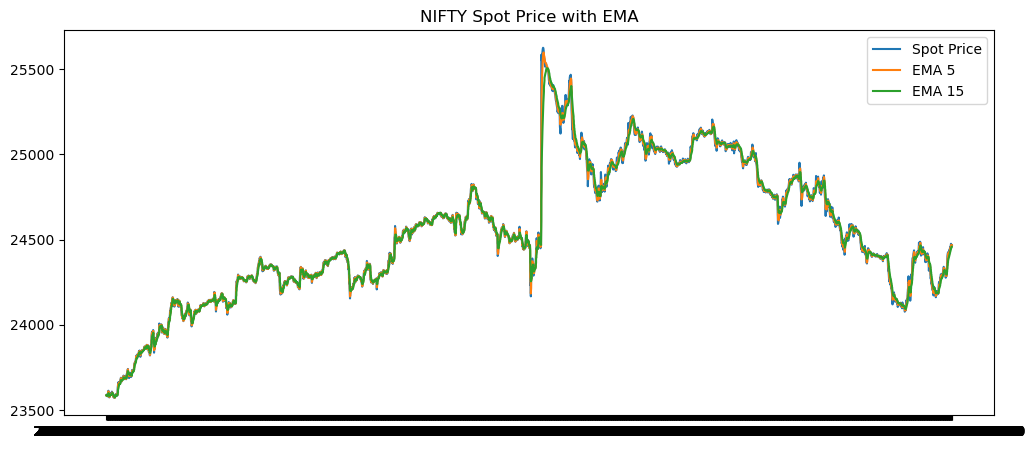

In [151]:
import matplotlib.pyplot as plt

df = pd.read_csv("C:/Users/HP/Desktop/MLQuest/dataset/nifty_features_final.csv")

plt.figure(figsize=(12,5))
plt.plot(df["datetime"], df["close_spot"], label="Spot Price")
plt.plot(df["datetime"], df["ema_5"], label="EMA 5")
plt.plot(df["datetime"], df["ema_15"], label="EMA 15")
plt.legend()
plt.title("NIFTY Spot Price with EMA")
plt.show()


In [152]:
!pip install py_vollib

In [153]:
df = pd.read_csv("C:/Users/HP/Desktop/MLQuest/dataset/nifty_features_final.csv")
df.head(10)

,datetime,stock_code_spot,exchange_code_spot,product_type_spot,expiry_date_spot,right_spot,strike_price_spot,open_spot,high_spot,low_spot,...,iv,delta,gamma,vega,theta,spot_return,pcr_oi,pcr_volume,ema_5,ema_15
0,2024-06-25 09:15:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23577.10,23590.90,23573.65,...,0.124732,0.208446,0.000346,1907.677787,-1786.658444,NaN,NaN,NaN,23586.050000,23586.050000
1,2024-06-25 09:15:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23577.10,23590.90,23573.65,...,0.124732,0.208446,0.000346,1907.677787,-1786.658444,0.000000,NaN,NaN,23586.050000,23586.050000
2,2024-06-25 09:20:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23586.70,23600.30,23572.90,...,0.110658,-0.819641,0.000357,1746.974973,-10.540271,0.000165,0.062750,0.0,23587.350000,23586.537500
3,2024-06-25 09:20:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23586.70,23600.30,23572.90,...,0.125011,0.210340,0.000347,1918.173193,-1800.910420,0.000000,0.062750,0.0,23588.216667,23586.964063
4,2024-06-25 09:20:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23586.70,23600.30,23572.90,...,0.110658,-0.819641,0.000357,1746.974973,-10.540271,0.000000,0.062750,0.0,23588.794444,23587.337305
5,2024-06-25 09:20:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23586.70,23600.30,23572.90,...,0.125011,0.210340,0.000347,1918.173193,-1800.910420,0.000000,0.062750,0.0,23589.179630,23587.663892
6,2024-06-25 09:25:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23589.55,23603.15,23581.40,...,0.124635,0.206651,0.000345,1897.576250,-1775.039337,-0.000363,0.061924,0.0,23586.586420,23586.880905
7,2024-06-25 09:25:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23589.55,23603.15,23581.40,...,0.112056,-0.819557,0.000353,1746.850438,-25.795406,0.000000,0.061924,0.0,23584.857613,23586.195792
8,2024-06-25 09:25:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23589.55,23603.15,23581.40,...,0.124635,0.206651,0.000345,1897.576250,-1775.039337,0.000000,0.061924,0.0,23583.705075,23585.596318
9,2024-06-25 09:25:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23589.55,23603.15,23581.40,...,0.112056,-0.819557,0.000353,1746.850438,-25.795406,0.000000,0.061924,0.0,23582.936717,23585.071778


In [154]:
df.columns.tolist()

['datetime',
 'stock_code_spot',
 'exchange_code_spot',
 'product_type_spot',
 'expiry_date_spot',
 'right_spot',
 'strike_price_spot',
 'open_spot',
 'high_spot',
 'low_spot',
 'close_spot',
 'volume_spot',
 'open_interest_spot',
 'count_spot',
 'stock_code_fut',
 'exchange_code_fut',
 'product_type_fut',
 'expiry_date_fut',
 'right_fut',
 'strike_price_fut',
 'open_fut',
 'high_fut',
 'low_fut',
 'close_fut',
 'volume_fut',
 'open_interest_fut',
 'count_fut',
 'expiry',
 'stock_code',
 'exchange_code',
 'product_type',
 'expiry_date',
 'right',
 'strike_price',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'open_interest',
 'count',
 'expiry_opt',
 'strike',
 'T',
 'iv',
 'delta',
 'gamma',
 'vega',
 'theta',
 'spot_return',
 'pcr_oi',
 'pcr_volume',
 'ema_5',
 'ema_15']

In [155]:
df["ema_5"] = df["close_spot"].ewm(span=5, adjust=False).mean()
df["ema_15"] = df["close_spot"].ewm(span=15, adjust=False).mean()


In [156]:
df["spot_return"] = df["close_spot"].pct_change()
df["fut_return"] = df["close_fut"].pct_change()


In [157]:
df["futures_basis"] = (
    df["close_fut"] - df["close_spot"]
) / df["close_spot"]


In [159]:
df["avg_iv"] = df["iv"]        
df["iv_spread"] = 0.0          


In [160]:

df["pcr_oi"] = df["pcr_oi"]
df["pcr_volume"] = df["pcr_volume"]


In [161]:
required_cols = [
    "ema_5", "ema_15",
    "avg_iv", "iv_spread",
    "pcr_oi", "pcr_volume",
    "futures_basis",
    "spot_return", "fut_return",
    "delta", "gamma", "vega", "theta"
]

missing = [c for c in required_cols if c not in df.columns]
print("Missing columns:", missing)


Missing columns: []


In [162]:
df.to_csv("C:/Users/HP/Desktop/MLQuest/dataset/nifty_features_final.csv", index=False)


In [163]:
from py_vollib.black_scholes.greeks.analytical import delta, gamma, theta, vega, rho

def calculate_greeks(S, K, r, t, flag, iv):
    return {
        "delta": delta(flag, S, K, t, r, iv),
        "gamma": gamma(flag, S, K, t, r, iv),
        "theta": theta(flag, S, K, t, r, iv),
        "vega": vega(flag, S, K, t, r, iv),
        "rho": rho(flag, S, K, t, r, iv),
    }


In [169]:

df['avg_iv'] = df['iv']
df['iv_spread'] = 0.0

df['pcr_oi'] = df['pcr_oi']
df['pcr_volume'] = df['pcr_volume']

df['futures_basis'] = (
    df['close_fut'] - df['close_spot']
) / df['close_spot']

df['spot_return'] = df['close_spot'].pct_change()
df['fut_return'] = df['close_fut'].pct_change()


In [174]:
df.to_csv(r"C:\Users\HP\Desktop\MLQuest\dataset\nifty_merged_5min.csv",index=False)


In [175]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM

In [179]:
df = pd.read_csv(r"C:\Users\HP\Desktop\MLQuest\dataset\nifty_features_final.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)
print("Loaded data:", df.shape)
df.head(10)


Loaded data: (8316, 58)


,datetime,stock_code_spot,exchange_code_spot,product_type_spot,expiry_date_spot,right_spot,strike_price_spot,open_spot,high_spot,low_spot,...,theta,spot_return,pcr_oi,pcr_volume,ema_5,ema_15,fut_return,futures_basis,avg_iv,iv_spread
0,2024-06-25 09:15:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23577.10,23590.90,23573.65,...,-1786.658444,NaN,NaN,NaN,23586.050000,23586.050000,NaN,-0.000045,0.124732,0.0
1,2024-06-25 09:15:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23577.10,23590.90,23573.65,...,-1786.658444,0.000000,NaN,NaN,23586.050000,23586.050000,0.005387,0.005342,0.124732,0.0
2,2024-06-25 09:20:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23586.70,23600.30,23572.90,...,-10.540271,0.000165,0.062750,0.0,23587.350000,23586.537500,-0.005232,-0.000083,0.110658,0.0
3,2024-06-25 09:20:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23586.70,23600.30,23572.90,...,-1800.910420,0.000000,0.062750,0.0,23588.216667,23586.964063,0.000000,-0.000083,0.125011,0.0
4,2024-06-25 09:20:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23586.70,23600.30,23572.90,...,-10.540271,0.000000,0.062750,0.0,23588.794444,23587.337305,0.005456,0.005373,0.110658,0.0
5,2024-06-25 09:20:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23586.70,23600.30,23572.90,...,-1800.910420,0.000000,0.062750,0.0,23589.179630,23587.663892,0.000000,0.005373,0.125011,0.0
6,2024-06-25 09:25:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23589.55,23603.15,23581.40,...,-1775.039337,-0.000362,0.061924,0.0,23586.586420,23586.880905,-0.005882,-0.000178,0.124635,0.0
7,2024-06-25 09:25:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23589.55,23603.15,23581.40,...,-25.795406,0.000000,0.061924,0.0,23584.857613,23586.195792,0.000000,-0.000178,0.112056,0.0
8,2024-06-25 09:25:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23589.55,23603.15,23581.40,...,-1775.039337,0.000000,0.061924,0.0,23583.705075,23585.596318,0.005533,0.005354,0.124635,0.0
9,2024-06-25 09:25:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23589.55,23603.15,23581.40,...,-25.795406,0.000000,0.061924,0.0,23582.936717,23585.071778,0.000000,0.005354,0.112056,0.0


In [181]:
hmm_features = [
    "avg_iv",
    "iv_spread",
    "pcr_oi",
    "delta",
    "gamma",
    "vega",
    "futures_basis",
    "spot_return"
]
hmm_df = df[hmm_features].dropna()
hmm_df.head(10)

,avg_iv,iv_spread,pcr_oi,delta,gamma,vega,futures_basis,spot_return
2,0.110658,0.0,0.062750,-0.819641,0.000357,1746.974973,-0.000083,0.000165
3,0.125011,0.0,0.062750,0.210340,0.000347,1918.173193,-0.000083,0.000000
4,0.110658,0.0,0.062750,-0.819641,0.000357,1746.974973,0.005373,0.000000
5,0.125011,0.0,0.062750,0.210340,0.000347,1918.173193,0.005373,0.000000
6,0.124635,0.0,0.061924,0.206651,0.000345,1897.576250,-0.000178,-0.000362
7,0.112056,0.0,0.061924,-0.819557,0.000353,1746.850438,-0.000178,0.000000
8,0.124635,0.0,0.061924,0.206651,0.000345,1897.576250,0.005354,0.000000
9,0.112056,0.0,0.061924,-0.819557,0.000353,1746.850438,0.005354,0.000000
16,0.127212,0.0,0.065252,0.216811,0.000347,1952.881758,0.001040,0.000706
17,0.120881,0.0,0.065252,-0.795556,0.000353,1886.724791,0.001040,0.000000


In [182]:
#Split train and test sets
split_index = int(0.7 * len(hmm_df))
train_data = hmm_df.iloc[:split_index]


In [183]:
hmm = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, random_state=42)
hmm.fit(train_data)

Model is not converging.  Current: 104428.90952864905 is not greater than 129549.43269115908. Delta is -25120.523162510028


,n_components,3
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,42


In [186]:
df.loc[hmm_df.index, "regime_raw"] = hmm.predict(hmm_df)

In [187]:
regime_map = {0: 0, 1: -1, 2: 1}
df["regime"] = df["regime_raw"].map(regime_map)
print(df["regime"].value_counts())

regime
 0.0    4528
 1.0    2835
-1.0     462
Name: count, dtype: int64


In [188]:
df.to_csv(r"C:/Users/HP/Desktop/MLQuest/dataset/nifty_features_with_regime.csv",index=False)
print("Regime detection completed & file saved")

Regime detection completed & file saved


In [189]:
df1 = pd.read_csv(r"C:/Users/HP/Desktop/MLQuest/dataset/nifty_features_with_regime.csv")
df1.head(10)

,datetime,stock_code_spot,exchange_code_spot,product_type_spot,expiry_date_spot,right_spot,strike_price_spot,open_spot,high_spot,low_spot,...,pcr_oi,pcr_volume,ema_5,ema_15,fut_return,futures_basis,avg_iv,iv_spread,regime_raw,regime
0,2024-06-25 09:15:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23577.10,23590.90,23573.65,...,NaN,NaN,23586.050000,23586.050000,NaN,-0.000045,0.124732,0.0,NaN,NaN
1,2024-06-25 09:15:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23577.10,23590.90,23573.65,...,NaN,NaN,23586.050000,23586.050000,0.005387,0.005342,0.124732,0.0,NaN,NaN
2,2024-06-25 09:20:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23586.70,23600.30,23572.90,...,0.062750,0.0,23587.350000,23586.537500,-0.005232,-0.000083,0.110658,0.0,1.0,-1.0
3,2024-06-25 09:20:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23586.70,23600.30,23572.90,...,0.062750,0.0,23588.216667,23586.964063,0.000000,-0.000083,0.125011,0.0,0.0,0.0
4,2024-06-25 09:20:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23586.70,23600.30,23572.90,...,0.062750,0.0,23588.794444,23587.337305,0.005456,0.005373,0.110658,0.0,0.0,0.0
5,2024-06-25 09:20:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23586.70,23600.30,23572.90,...,0.062750,0.0,23589.179630,23587.663892,0.000000,0.005373,0.125011,0.0,0.0,0.0
6,2024-06-25 09:25:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23589.55,23603.15,23581.40,...,0.061924,0.0,23586.586420,23586.880905,-0.005882,-0.000178,0.124635,0.0,0.0,0.0
7,2024-06-25 09:25:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23589.55,23603.15,23581.40,...,0.061924,0.0,23584.857613,23586.195792,0.000000,-0.000178,0.112056,0.0,0.0,0.0
8,2024-06-25 09:25:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23589.55,23603.15,23581.40,...,0.061924,0.0,23583.705075,23585.596318,0.005533,0.005354,0.124635,0.0,0.0,0.0
9,2024-06-25 09:25:00,NIFTY,NSE,NaN,NaN,NaN,NaN,23589.55,23603.15,23581.40,...,0.061924,0.0,23582.936717,23585.071778,0.000000,0.005354,0.112056,0.0,0.0,0.0


In [196]:
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)
df.columns.tolist()

['datetime',
 'stock_code_spot',
 'exchange_code_spot',
 'product_type_spot',
 'expiry_date_spot',
 'right_spot',
 'strike_price_spot',
 'open_spot',
 'high_spot',
 'low_spot',
 'close_spot',
 'volume_spot',
 'open_interest_spot',
 'count_spot',
 'stock_code_fut',
 'exchange_code_fut',
 'product_type_fut',
 'expiry_date_fut',
 'right_fut',
 'strike_price_fut',
 'open_fut',
 'high_fut',
 'low_fut',
 'close_fut',
 'volume_fut',
 'open_interest_fut',
 'count_fut',
 'expiry',
 'stock_code',
 'exchange_code',
 'product_type',
 'expiry_date',
 'right',
 'strike_price',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'open_interest',
 'count',
 'expiry_opt',
 'strike',
 'T',
 'iv',
 'delta',
 'gamma',
 'vega',
 'theta',
 'spot_return',
 'pcr_oi',
 'pcr_volume',
 'ema_5',
 'ema_15',
 'fut_return',
 'futures_basis',
 'avg_iv',
 'iv_spread',
 'regime_raw',
 'regime',
 'signal']

In [191]:
df["signal"] = 0
df.loc[
    (df["ema_5"] > df["ema_15"]) &
    (df["ema_5"].shift(1) <= df["ema_15"].shift(1)) &
    (df["regime"] == 1),
    "signal"
] = 1

df.loc[
    (df["ema_5"] < df["ema_15"]) &
    (df["ema_5"].shift(1) >= df["ema_15"].shift(1)) &
    (df["regime"] == -1),
    "signal"
] = -1


In [197]:
df["position"] = df["signal"].replace(0, np.nan).ffill().fillna(0)
df["strategy_return"] = df["position"].shift(1) * df["spot_return"]
df["cum_return"] = (1 + df["strategy_return"]).cumprod()


In [198]:
total_return = df["cum_return"].iloc[-1] - 1
sharpe = ( df["strategy_return"].mean() /  df["strategy_return"].std() * np.sqrt(252 * 78) )  
max_dd = ( df["cum_return"] /  df["cum_return"].cummax() - 1).min()
print("Total Return:", round(total_return * 100, 2), "%")
print("Sharpe Ratio:", round(sharpe, 2))
print("Max Drawdown:", round(max_dd * 100, 2), "%")

Total Return: 1.1 %
Sharpe Ratio: 0.31
Max Drawdown: -5.9 %


In [199]:

df["trade"] = df["signal"].diff().abs().fillna(0)
total_trades = int(df["trade"].sum())


In [200]:
wins = df[df["strategy_return"] > 0]["strategy_return"]
losses = df[df["strategy_return"] < 0]["strategy_return"]

win_rate = len(wins) / (len(wins) + len(losses))
profit_factor = wins.sum() / abs(losses.sum())


In [201]:
downside_std = df.loc[df["strategy_return"] < 0, "strategy_return"].std()

sortino = (
    df["strategy_return"].mean() / downside_std
) * np.sqrt(252 * 78)


In [202]:
total_return = df["cum_return"].iloc[-1] - 1

max_dd = (
    df["cum_return"] /
    df["cum_return"].cummax() - 1
).min()

calmar = total_return / abs(max_dd)


In [203]:
trade_groups = (df["position"] != df["position"].shift()).cumsum()
avg_trade_duration = df.groupby(trade_groups).size().mean()


In [205]:
print("Total Trades:", total_trades,"\n")
print("Total Return:", round(total_return * 100, 2), "%")
print("Sharpe Ratio:", round(sharpe, 2))
print("Sortino Ratio:", round(sortino, 2))
print("Calmar Ratio:", round(calmar, 2))
print("Max Drawdown:", round(max_dd * 100, 2), "%")
print("Win Rate:", round(win_rate * 100, 2), "%")
print("Profit Factor:", round(profit_factor, 2))
print("Avg Trade Duration (candles):", round(avg_trade_duration, 2))

Total Trades: 298 

Total Return: 1.1 %
Sharpe Ratio: 0.31
Sortino Ratio: 0.16
Calmar Ratio: 0.19
Max Drawdown: -5.9 %
Win Rate: 51.42 %
Profit Factor: 1.02
Avg Trade Duration (candles): 319.85


In [207]:
df.to_csv(r"C:/Users/HP/Desktop/MLQuest/dataset/nifty_backtest_results.csv",index=False)


In [208]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


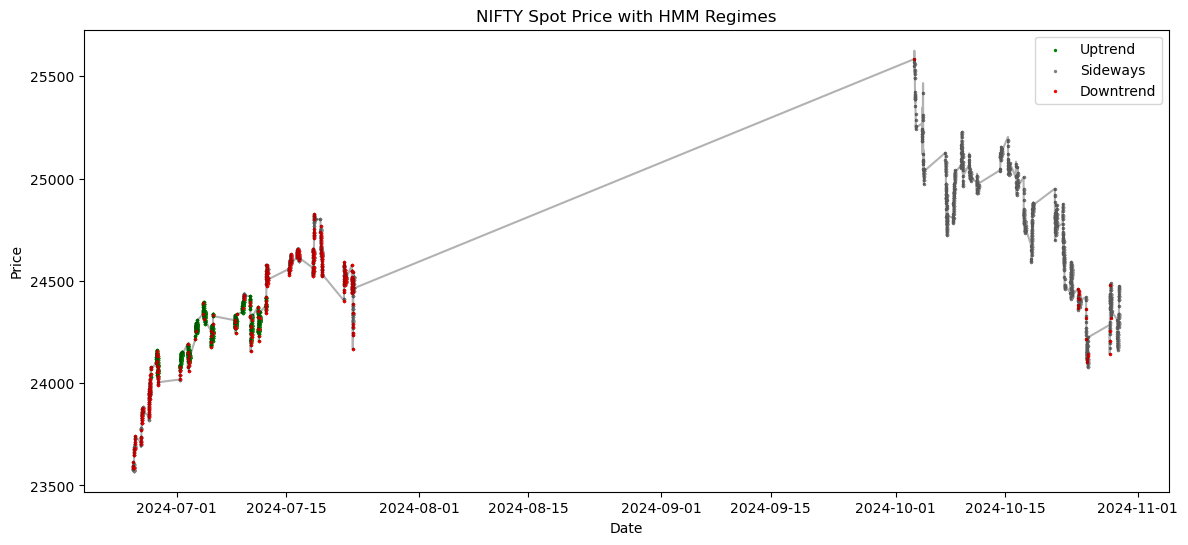

In [209]:
plt.figure(figsize=(14,6))

for regime, color, label in [
    (1, "green", "Uptrend"),
    (0, "gray", "Sideways"),
    (-1, "red", "Downtrend")
]:
    subset = df[df["regime"] == regime]
    plt.scatter(
        subset["datetime"],
        subset["close_spot"],
        c=color,
        s=2,
        label=label
    )

plt.plot(df["datetime"], df["close_spot"], color="black", alpha=0.3)
plt.title("NIFTY Spot Price with HMM Regimes")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


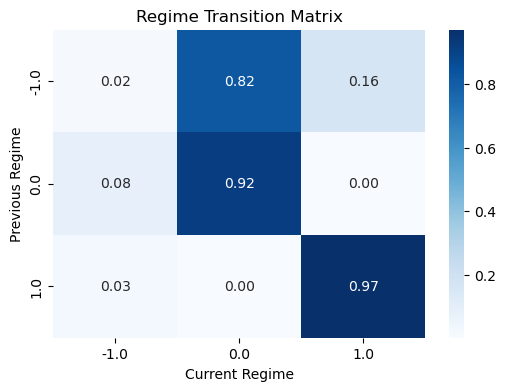

In [210]:
transition_matrix = pd.crosstab(
    df["regime"].shift(1),
    df["regime"],
    normalize="index"
)

plt.figure(figsize=(6,4))
sns.heatmap(
    transition_matrix,
    annot=True,
    cmap="Blues",
    fmt=".2f"
)
plt.title("Regime Transition Matrix")
plt.xlabel("Current Regime")
plt.ylabel("Previous Regime")
plt.show()


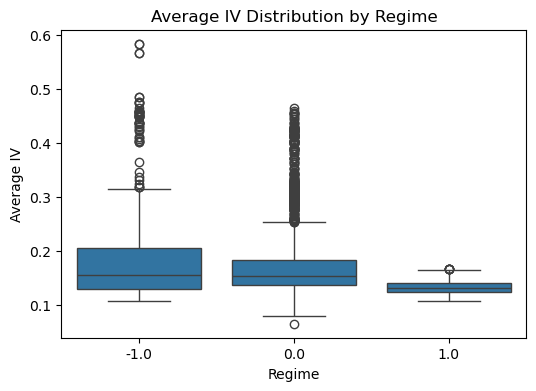

In [211]:
plt.figure(figsize=(6,4))
sns.boxplot(
    x="regime",
    y="avg_iv",
    data=df
)
plt.title("Average IV Distribution by Regime")
plt.xlabel("Regime")
plt.ylabel("Average IV")
plt.show()


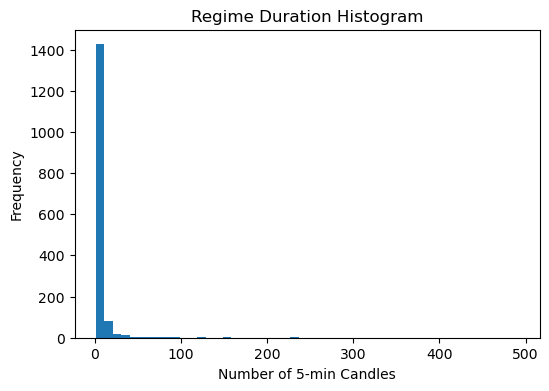

In [212]:
regime_blocks = (df["regime"] != df["regime"].shift()).cumsum()
regime_duration = df.groupby(regime_blocks).size()

plt.figure(figsize=(6,4))
plt.hist(regime_duration, bins=50)
plt.title("Regime Duration Histogram")
plt.xlabel("Number of 5-min Candles")
plt.ylabel("Frequency")
plt.show()
